#### 데이터 확인

In [2]:
import pandas as pd
# 판다스 출력 결과를 소수점 둘째 자리 까지로 제한
pd.options.display.float_format = '{:,.2f}'.format
# 고객 254명의 상품 구매 관련 데이터 불러오기
sales_df = pd.read_csv('data/sales_data.csv', index_col=['customer_id'])
sales_df.head()

,total_buy_cnt,total_price
customer_id,,
12395,99,430250
12427,98,566410
12431,122,849900
12433,625,1180950
12471,10,97750


#### 데이터 분포 확인

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

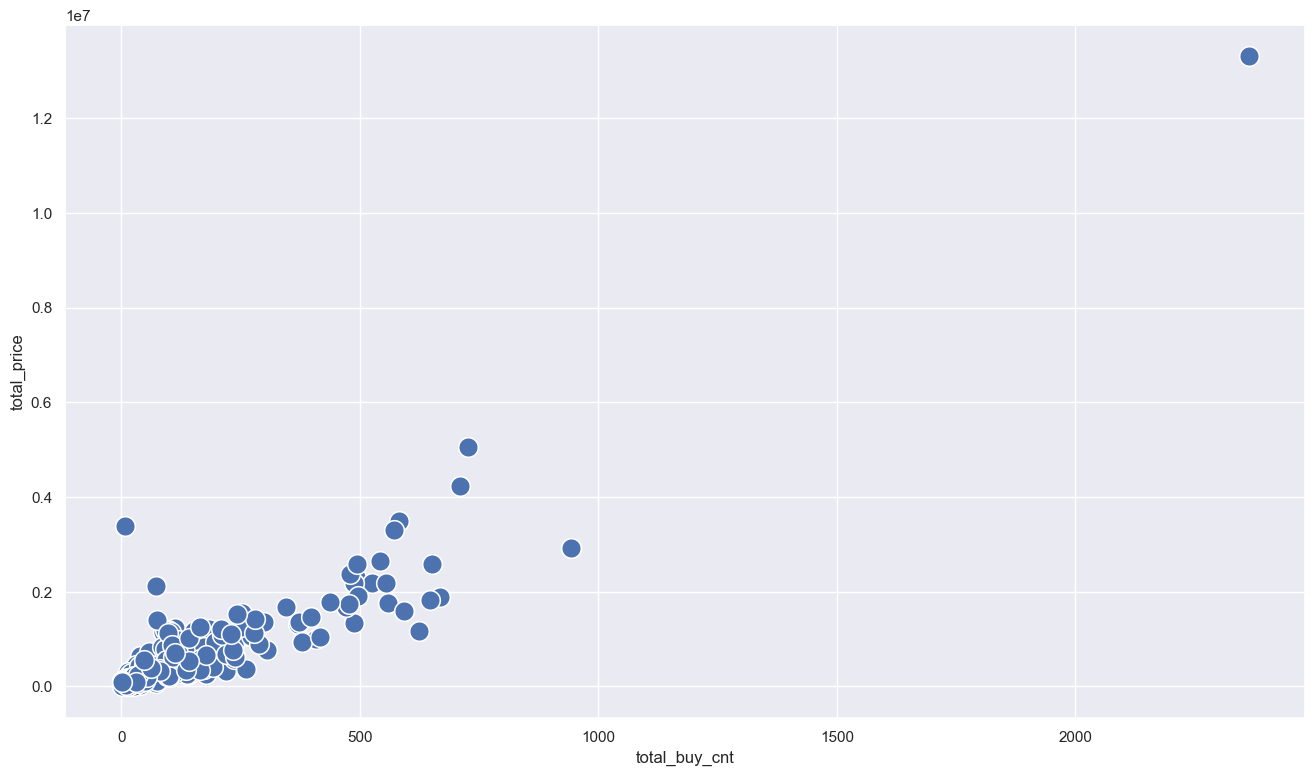

In [11]:
import seaborn as sns
sns.set(style="darkgrid",
        rc={'figure.figsize':(16,9)})

# 데이터 시각화
sns.scatterplot(x=sales_df['total_buy_cnt'], y=sales_df['total_price'], s=200)

#### 이상치 제거

In [12]:
# 이상치 제거 함수
def get_outlier(df):   
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1

    range_min = Q1 - IQR * 1.5
    range_max = Q3 + IQR * 1.5

    outlier_column = (df < range_min) | (df > range_max)
    
    # any(axis=1): 각 행에 대해 하나라도 True 값이 있으면 True를 반환
    is_outlier = outlier_column.any(axis=1)

    return is_outlier

Index([12433, 12838, 13013, 13145, 13705, 14083, 14449, 14573, 14729, 14911,
       15012, 15061, 15525, 15574, 15862, 16244, 16274, 16891, 16916, 17198,
       17238, 17841, 17850, 17908, 17920, 17967, 17968, 17976, 18041],
      dtype='int64', name='customer_id')


<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

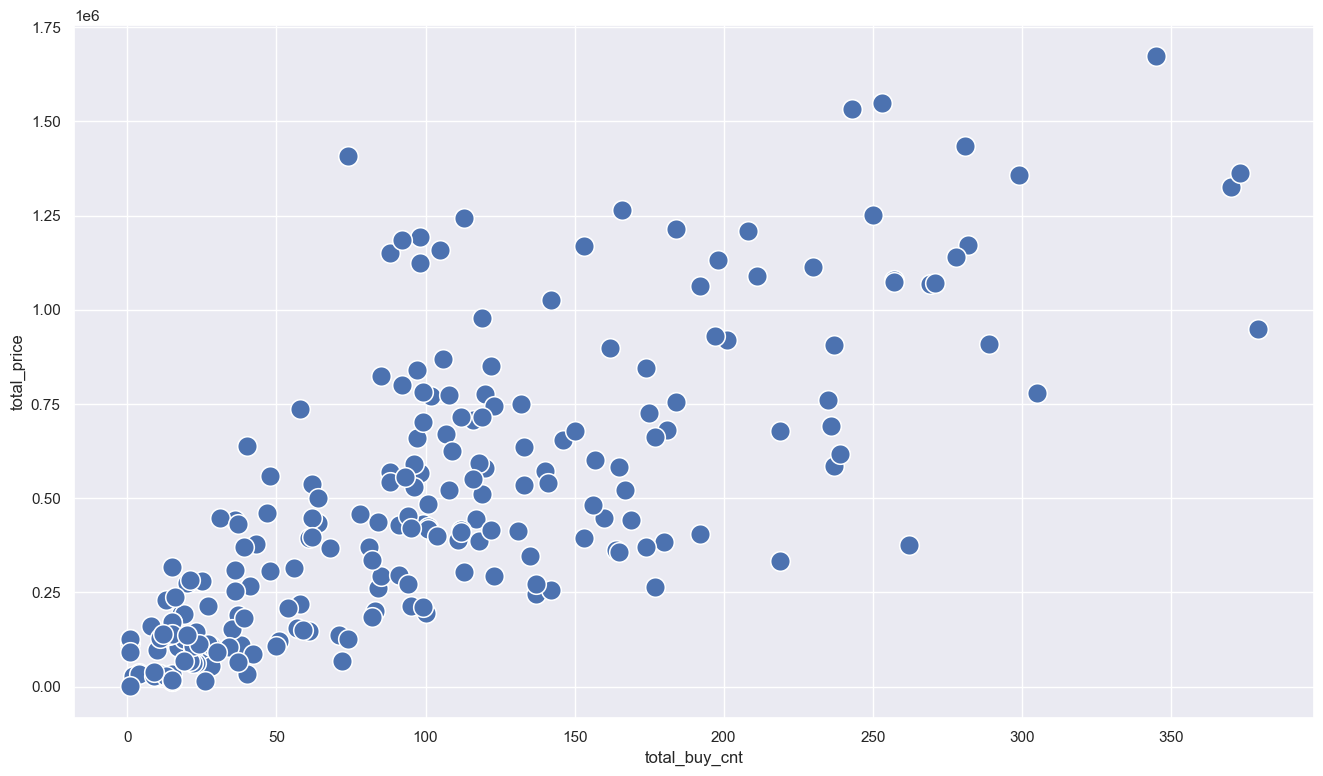

In [13]:
# 이상치 
outlier_df = get_outlier(sales_df)

# 이상치 인덱스 추출
outlier_index = sales_df[outlier_df].index
print(outlier_index)

# 이상치 제거
sales_df = sales_df.drop(outlier_index)

# 이상치 제거한 데이터프레임 시각화
sns.scatterplot(x=sales_df['total_buy_cnt'], y=sales_df['total_price'], s=200)

#### 데이터 표준화(Standardization)
- 데이터를 보면 total_buy_cnt는 단위가 1개이고, 가장 큰 값은 350개입니다. 하지만, total_price는 기본 단위가 10,000원입니다. 두 변수의 단위 통일이 필요

In [18]:
from sklearn.preprocessing import StandardScaler

# StandardScaler를 사용하여 데이터를 스케일링
scaler = StandardScaler()
scaled_df = scaler.fit_transform(sales_df)

# 스케일링된 데이터를 데이터프레임으로 변환하고, 인덱스와 컬럼명 설정
scaled_df = pd.DataFrame(scaled_df, index=sales_df.index, columns=sales_df.columns)

scaled_df

,total_buy_cnt,total_price
customer_id,,
12395,-0.05,-0.15
12427,-0.07,0.21
12431,0.23,0.95
12471,-1.13,-1.03
12472,-0.19,0.21
...,...,...
18144,-0.89,-1.05
18168,1.70,2.75
18225,-1.24,-1.04


#### k-means 모델 학습

In [19]:
# 라이브러리 불러오기
from sklearn.cluster import KMeans

#### KMeans 함수 모델 선언
- n_clusters: 클러스터를 몇 개로 나눌지, 즉 k를 몇으로 할지 결정해 주는 파라미터
- random_state: 여러 번 반복해서 모델을 학습시킬 때 동일한 결과가 나올 수 있도록 해 주는 난수

In [20]:
# k-means(k=2)
model = KMeans(n_clusters=2, random_state=123)

In [21]:
# 모델 학습
model.fit(scaled_df)

KMeans(n_clusters=2, random_state=123)

#### 클러스터 시각화
- predict()를 활용해 각 데이터가 어떤 클러스터로 구분됐는지 (0, 1) 표시

In [22]:
# label 컬럼 생성
scaled_df['label'] = model.predict(scaled_df)
scaled_df

,total_buy_cnt,total_price,label
customer_id,,,
12395,-0.05,-0.15,0
12427,-0.07,0.21,0
12431,0.23,0.95,1
12471,-1.13,-1.03,0
12472,-0.19,0.21,0
...,...,...,...
18144,-0.89,-1.05,0
18168,1.70,2.75,1
18225,-1.24,-1.04,0


[[-0.56591372 -0.61132398]
 [ 0.9499266   1.02615097]]


<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

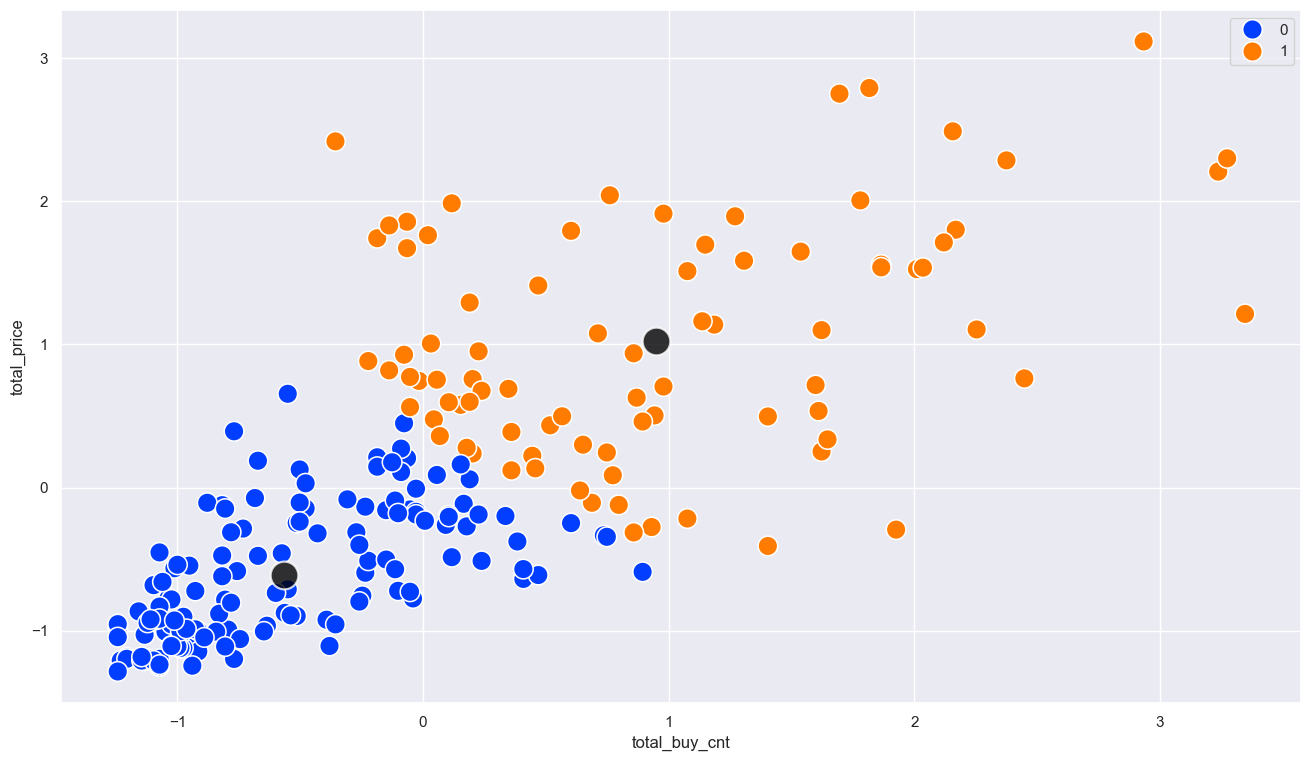

In [23]:
# 라벨링 된 데이터를 기준으로 클러스터를 구분해 시각화
# 중심점(Centroid) 표시
centers = model.cluster_centers_
print(centers)
# 산점도
sns.scatterplot(x=scaled_df['total_buy_cnt'], y=scaled_df['total_price'], hue=scaled_df['label'], s=200, palette='bright')
# 중심점 표시
sns.scatterplot(x=centers[:,0], y=centers[:,1], color='black', alpha=0.8, s=400)

#### 최적의 k 선정 기준
k-means는 k 개의 Centroid에 가까이 모여 있는 데이터들을 하나의 클러스터로 묶어 주는 방법, 
클러스터마다 속한 데이터와 Centroid 사이 거리의 합이 작아야 잘 된 클러스터링입니다.
그걸 확인하기 위해 사용하는 값이 바로 inertia(이너시아)입니다. 
inertia: 각 클러스터에 속한 데이터들과 Centroid 사이의 거리를 제곱해서 전부 더한 값

In [24]:
# inertia 값 확인
print(model.inertia_)

187.9003819847124


#### Elbow Method
k를 하나로만 정의해서 inertia를 구하면 해당 값이 큰 것인지 작은 것인지 판단하기가 어려움 
따라서, 서로 다른 k 값 여러 개로 모델을 만든 다음에 각각의 inertia 값을 비교

In [25]:
# scaled_df에 추가했던 label 열을 제거
scaled_df = scaled_df.drop(['label'], axis=1)

<Axes: >

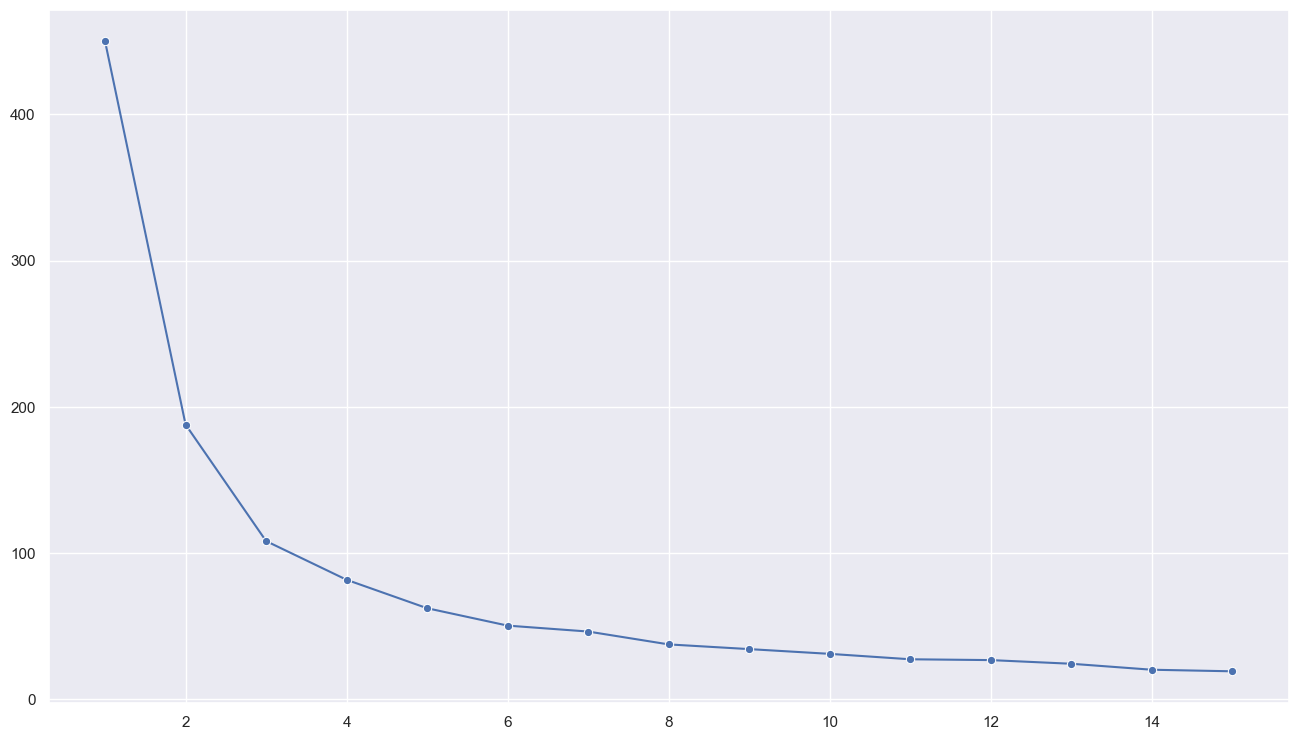

In [26]:
# inertia 값 저장할 리스트
inertias = []     

for k in range(1, 16): # k값의 범위 1~15로 지정
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(scaled_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
sns.lineplot(x=range(1, 16), y=inertias, marker='o')

최적의 클러스터 개수는 inertia가 충분히 작지만, 분석 목적에 부합하도록 적당해야 합니다. 그리고, 보통 그 지점은 시각화 한 그래프의 기울기가 급격하게 줄어드는 구간으로 정의합니다. 예를 들어 위의 그래프를 보면, k 값이 2~3 사이인 구간에서 기울기가 급격하게 줄어들고 있는데요. 따라서 여기서 최적의 k 값은 2나 3이라고 볼 수 있습니다. 이때 그래프의 모양이 마치 팔꿈치 모양 같다고 해서, 이런 식으로 클러스터 개수를 찾는 방법을 Elbow Method라고 부른다.

In [27]:
# k=5로 클러스터링 진행
model = KMeans(n_clusters=5, random_state=123)
model.fit(scaled_df)

KMeans(n_clusters=5, random_state=123)

In [28]:
sales_df['label'] = model.predict(scaled_df)

#### 클러스터링 결과 해석

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

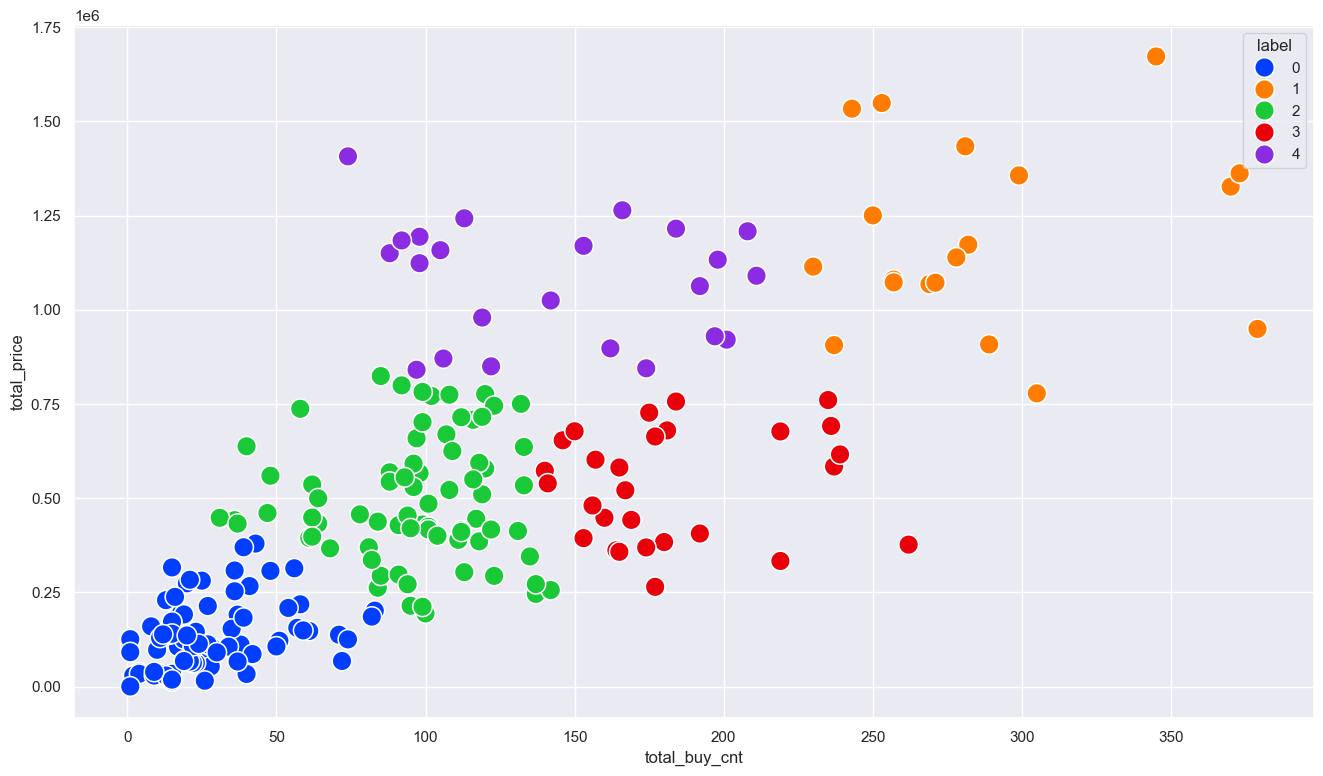

In [29]:
# 시각화
sns.scatterplot(x= sales_df['total_buy_cnt'], y= sales_df['total_price'], hue= sales_df['label'], s=200, palette='bright')

In [30]:
# 5개의 그룹 고객 수 확인
pd.DataFrame(sales_df['label'].value_counts())

,count
label,
0,81
2,74
3,28
4,23
1,19


In [31]:
# 평균 개당 가격 구하기
groupby_df = sales_df.groupby('label').mean()
groupby_df['price_mean'] = groupby_df['total_price'] / groupby_df['total_buy_cnt']
groupby_df

,total_buy_cnt,total_price,price_mean
label,,,
0,27.63,"134,258.02","4,859.20"
1,287.79,"1,197,027.89","4,159.39"
2,96.42,"493,092.97","5,114.07"
3,182.86,"532,944.29","2,914.54"
4,143.48,"1,076,521.30","7,503.03"


#### 각 클러스터의 특징 분석
- 클러스터 1의 고객들은 총 구매 수량과 금액이 가장 많습니다. 하지만, 개당 구매 가격은 적은 편입니다. 해당 클러스터의 고객들은 가격이 낮은 물품을 많이 구매한다는 특징이 있는 걸로 해석할 수 있다.
- 클러스터 4의 고객들은 총 구매 수량이 많은 편은 아니지만, 구매한 품목의 평균 금액은 높은 편이다. 수량은 많지 않지만 비싼 물품을 사는 고객들이라는 걸 알 수 있다.
- 결과를 바탕으로 프로모션을 진행하면 고객 클러스터별 특징에 따라 맞춤 전략을 짤 수 있다. 저렴한 물품을 여러 번 구매하면 사은품을 주는 행사는 1번 클러스터 고객들에게, 가격이 높은 제품의 할인 프로모션은 4번 클러스터 고객들에게 진행하면 효과가 더 좋음을 알 수 있다.